# Example analysis of cleavage rate dispersion model
Below is an example of how to load and visualize a dispersion model create using `ftd-learn-dispersion-model` that forms the statistical basis for footprint detection.

In [1]:
import numpy as np
import scipy.stats

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

### Load dispersion model file

Here we remotely load the the dispersion model created for human regulatory T cells

In [3]:
from footprint_tools.modeling import dispersion
dm = dispersion.read_dispersion_model("https://resources.altius.org/~jvierstra/projects/footprinting.2020/per.dataset/hTreg-DS14702/dm.json")

### Plot overall model parameters

The negative binomial distrubution has two parameters: mean and variance. The dispersion model is constructed by performing a MLE fit for each predicted cleavage rate and then smoothing the parameters using a piece-wise regression. The code below plots the MLE fit paramters (blue lines) and the piece-wise regression (dashed orange).

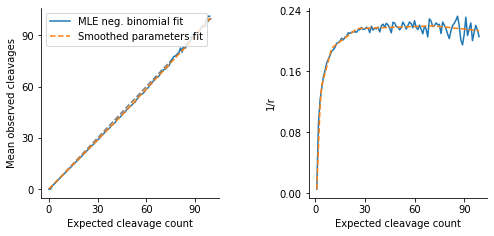

In [11]:
xx = np.arange(0, 100)
yy = np.array([dm.fit_mu(x) for x in xx])

r = np.array([dm.r[x] for x in xx])
p = np.array([dm.p[x] for x in xx])
mu = p*r/(1.0-p)

fit_mu = np.array([dm.fit_mu(x) for x in xx])
fit_r = np.array([dm.fit_r(x) for x in xx])

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, wspace = 0.5)

ax = fig.add_subplot(gs[0, 0])

ax.plot(xx, mu, label = "MLE neg. binomial fit")
ax.plot(xx, fit_mu, label = "Smoothed parameters fit", ls='dashed')
ax.plot([0, 100], [0, 100], color = 'grey', ls = '--', zorder=-10)

ax.set_xlabel("Expected cleavage count")
ax.set_ylabel("Mean observed cleavages")

[ax.spines[loc].set_color("none") for loc in ["top", "right"]]
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(direction = "out")
ax.xaxis.set(major_locator = MaxNLocator(4))

ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(direction = "out")
ax.yaxis.set(major_locator = MaxNLocator(4))

ax.legend()


ax = fig.add_subplot(gs[0, 1])

ax.plot(xx[1:], 1/r[1:])
ax.plot(xx[1:], 1/fit_r[1:], ls='dashed')

ax.set_xlabel("Expected cleavage count")
ax.set_ylabel("1/r")

[ax.spines[loc].set_color("none") for loc in ["top", "right"]]
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(direction = "out")
ax.xaxis.set(major_locator = MaxNLocator(4))

ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(direction = "out")
ax.yaxis.set(major_locator = MaxNLocator(4))

fig.set_size_inches(8, 3.5)

plt.show()

### Plot fit for a predicted cleavage rate

The code below plots the probability density for a single predicted cleavage rate. The negative binomial distribution shown (orange) is used in the statistical tests for cleavage deviation (lower-tail p-value) and for footprint likelihood functions (probability density function). A Poisson distrubution is additionally plotted to demonstrate overdispersion.

In [20]:
def plot_histogram(dm, n=25, show_poisson=True, ax=None):
    """Plots a density histogram of the observed cleavage counts]
    at an expected cleavage rate (n).
    """
    x=np.arange(125)
    
    ax.bar(x, dm.h[n,:125]/np.sum(dm.h[n,:]), width=1, color='lightgrey', label="Observed")
    
    mu=dm.fit_mu(n)
    r=dm.fit_r(n)
    
    if show_poisson:
        y_pois=scipy.stats.poisson.pmf(x, mu=n)
        ax.plot(x, y_pois, color="blue", label="Poisson (lambda=%d)" % n)

    y_nbinom=scipy.stats.nbinom.pmf(x, r, r/(r+mu))
    ax.plot(x, y_nbinom, color="red", label="Negative binomial")
    
    
    ax.set_xlim(0, 125)
    
    [ax.spines[loc].set_visible(False) for loc in ["top", "right"]]
    ax.set_xlabel("Observed DNase I cleavage counts")
    ax.set_ylabel("Density")
    
    ax.set_title("Observed cleavage counts at positions with %d expected cleavages" % n)
    
    ax.legend()

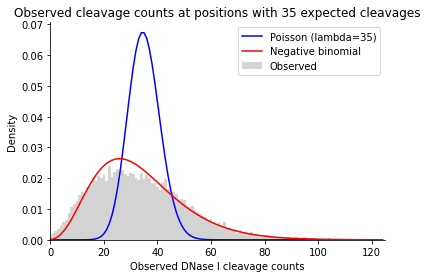

In [21]:
fig,ax=plt.subplots()
plot_histogram(dm,n=35, ax=ax)

plt.show()